In [1]:
from collections import Counter
import json
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Load the dataset json
json_filename = r"C:\Users\lukeasargen\projects\DataCoco\dataset_coco.json"
full_data = json.load(open(json_filename))

In [3]:
# Split sizes
Counter([o["split"] for o in full_data["images"]])

Counter({'test': 5000, 'restval': 30504, 'val': 5000, 'train': 82783})

In [4]:
# Number of captions per sentence in test and val
for split in [["train"], ["restval"], ["test"], ["val"], ["train", "restval"], ["train", "restval", "test", "val"]]:
    c = Counter([len(o["sentids"]) for o in full_data["images"] if o["split"] in split])
    print(f"{split} caption counts", c)
    print(f"{split} total images:", sum(c.values()))
    print(f"{split} total captions :", sum([k*v for k,v in c.items()]))

['train'] caption counts Counter({5: 82586, 6: 196, 7: 1})
['train'] total images: 82783
['train'] total captions : 414113
['restval'] caption counts Counter({5: 30393, 6: 108, 7: 3})
['restval'] total images: 30504
['restval'] total captions : 152634
['test'] caption counts Counter({5: 4990, 6: 10})
['test'] total images: 5000
['test'] total captions : 25010
['val'] caption counts Counter({5: 4990, 6: 10})
['val'] total images: 5000
['val'] total captions : 25010
['train', 'restval'] caption counts Counter({5: 112979, 6: 304, 7: 4})
['train', 'restval'] total images: 113287
['train', 'restval'] total captions : 566747
['train', 'restval', 'test', 'val'] caption counts Counter({5: 122959, 6: 324, 7: 4})
['train', 'restval', 'test', 'val'] total images: 123287
['train', 'restval', 'test', 'val'] total captions : 616767


In [5]:
len_count = Counter()
data = []
for img_data in full_data["images"]:
    for sent in img_data["sentences"]:
        data.append([img_data["split"], len(sent["tokens"])])
        len_count.update([len(sent["tokens"])])
df = pd.DataFrame(data=data, columns=["Split", "Length"])

c:\Users\lukeasargen\anaconda3\envs\pytorch\lib\site-packages\pandas\plotting\_matplotlib\hist.py:412: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


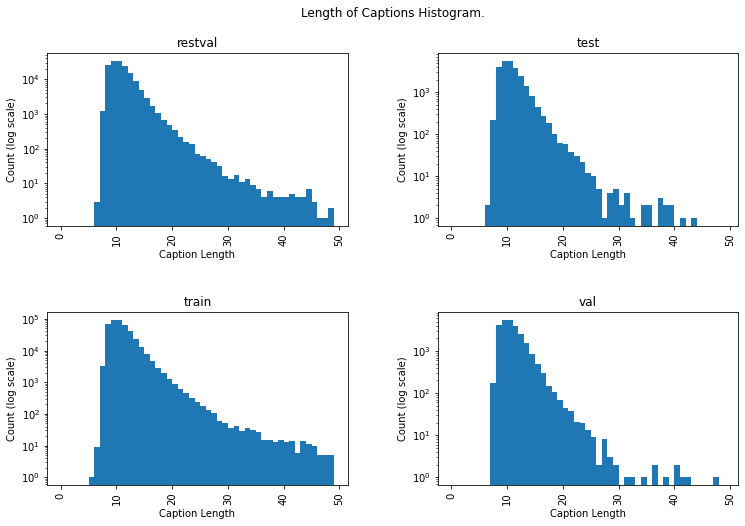

In [6]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_facecolor('w')
ax = plt.gca()
axes = df.hist(by="Split", ax=ax, bins=np.arange(0, max(len_count.keys())+1, 1), log=True)
for a in axes.flatten():
    a.set_xlabel("Caption Length")
    a.set_ylabel("Count (log scale)")
fig.suptitle("Length of Captions Histogram.")
plt.savefig(f"data/caption_length_histogram.png", bbox_inches="tight")

In [7]:
# Number of captions per sentence
Counter([len(o["sentids"]) for o in full_data["images"]])

Counter({5: 122959, 6: 324, 7: 4})

In [19]:
coco_image_folder = r"C:\Users\lukeasargen\projects\DataCoco"
output_folder = "data/coco"

# Dataset params
json_name = "10k256_glove100e_3072v"
ref_sentences = 5 # ^ most frequent from the counts above
min_count = 5  # Minimum count of the word to be considered for vocab
max_vocab = 3072  # Limit the vocab to the most frequent words
max_cap_length = 26  # Exclude super long captions
dev_train_keep = 10240  # Set to None for the full dataset
dev_val_keep = 1024  # also test_count

# embedding params
pretrained_dim = None  # None, 50, 100, 200, 300
pretrained_file = r"C:\Users\lukeasargen\projects\glove.6B" + f"\glove.6B.{pretrained_dim}d.txt"
extend_dim = True  # Add extra dimension that pads the pretrained embeddings with zeros, separates pretrained from random in the embedding space


In [20]:
# Iterate through the data and extract what is needed
word_freq = Counter()  # Get all the words for ranking by frequency
first_word_freq = Counter()  # I am curious about the first word
length_count = Counter()  # Count the lengths just to see what's there
totals_count = Counter()  # Total targets per image
train_img, test_img, val_img = [], [], []  # List of image file names
train_cap, test_cap, val_cap = [], [], []  # List of string tokens
train_len, test_len, val_len = [], [], []  # List of caption lengths

# For each image
for img_data in full_data["images"]:
    img_caps = []  # To be filled with lists of caption tokens
    cap_lens = []  # To be filled with lists of caption lengths

    # The absolute path of the dataset may be different than mine
    sub_folder = "train2014" if ("train" in img_data["filename"]) else "val2014"
    abs_img_path = os.path.join(coco_image_folder, sub_folder, img_data["filename"])

    # Images have multiple captions
    for sent in img_data["sentences"]:

        # This shows up a bunch so I remove it
        if "i am unable to see" in sent["raw"].lower(): continue
        
        # Capitalization adds more tokens, I just used all lowercase tokens
        # I also fix some common spelling errors
        sp = lambda s : s.lower().replace("tolet", "toilet").replace("skiis", "skis").replace("porduce", "produce").replace("raquet", "racket")
        tokens = [sp(t) for t in sent["tokens"]]
        
        # Data loader requires the length to by the same so it can stack the tensors
        if len(tokens) > max_cap_length: 
            tokens = tokens[:max_cap_length]

        img_caps.append(tokens)  # Collect this for test and val
        cap_lens.append(len(tokens)+1)  # Collect this for test and val, add 1 for <START> token

        length_count.update([len(tokens)])  # Update frequency of the lengths
        word_freq.update(tokens)  # Count the frequency of the string tokens
        first_word_freq.update([tokens[0]])
    
    # No captions were below max_cap_length
    if img_caps==[]: continue
    # Enforces the validation batches have the same number of references so the tensors have the same shape
    while ref_sentences > len(img_caps):
        idx = random.randint(0, len(img_caps)-1)
        img_caps.append(img_caps[idx])
        cap_lens.append(cap_lens[idx])
    if ref_sentences < len(img_caps):
        img_caps = img_caps[:ref_sentences]
        cap_lens = cap_lens[:ref_sentences]

    # Update the sum of target tokens
    totals_count.update([sum(cap_lens)])

    # For test and val, add the captions as lists
    if img_data["split"] in ["train", "restval"]:
        if len(train_img) >= dev_train_keep and dev_train_keep is not None: continue
        train_img.append(abs_img_path)
        train_cap.append(img_caps)
        train_len.append(cap_lens)
    elif img_data["split"]=="test":
        if len(test_img) >= dev_val_keep and dev_val_keep is not None: continue
        test_img.append(abs_img_path)
        test_cap.append(img_caps)
        test_len.append(cap_lens)
    elif img_data["split"]=="val":
        if len(val_img) >= dev_val_keep and dev_val_keep is not None: continue
        val_img.append(abs_img_path)
        val_cap.append(img_caps)
        val_len.append(cap_lens)

    if len(train_img)>=dev_train_keep and min(len(test_img),len(val_img))>=dev_val_keep and dev_train_keep is not None and dev_val_keep is not None: break

# End loop
print("Max Token Length :", max(length_count))
print(f"Train = {len(train_img)}")
print(f"Test = {len(test_img)}")
print(f"Val = {len(val_img)}")

Max Token Length : 26
Train = 10240
Test = 1024
Val = 1024


In [21]:
# If the captions are shorter than max_cap_length, reassign it to the longest caption length
max_cap_length = min(max_cap_length, max(list(length_count.keys())) )
print(f"{max_cap_length = }")
# Distribution of the caption lengths
sorted(length_count.items(), reverse=True)[:10]

max_cap_length = 26


[(26, 101),
 (25, 21),
 (24, 39),
 (23, 60),
 (22, 59),
 (21, 95),
 (20, 127),
 (19, 206),
 (18, 289),
 (17, 486)]

In [22]:
sorted(totals_count.items(), reverse=True)[:10]

[(92, 1),
 (90, 1),
 (89, 1),
 (88, 3),
 (87, 1),
 (86, 4),
 (85, 4),
 (84, 5),
 (83, 9),
 (82, 4)]

In [23]:
total_tokens = sum(word_freq.values())
print(f"Total Tokens = {total_tokens}")
print(f"Unique Vocab = {len(word_freq)}")

train_count = Counter([j for x in train_cap for i in x for j in i])
test_count = Counter([j for x in test_cap for i in x for j in i])
val_count = Counter([j for x in val_cap for i in x for j in i])
# Number of unique tokens between the sets
x = set(train_count.keys())
print(f"Vocab seen in training = {len(x)} ({100*len(x)/len(word_freq):.2f}%)")
# Not seen in training
not_seen = set(word_freq.keys()) - set(x)
print(f"Not seen in training = {len(not_seen)}")

Total Tokens = 707809
Unique Vocab = 10910
Vocab seen in training = 9679 (88.72%)
Not seen in training = 1231


In [24]:
word_freq.most_common(5)

[('a', 111870), ('on', 24646), ('of', 23542), ('the', 22667), ('in', 21161)]

In [25]:
first_word_freq.most_common(5)

[('a', 46446), ('two', 3664), ('the', 3020), ('an', 2194), ('there', 1372)]

In [26]:
# Get all the words that have enough counts
words = [k for k,v in word_freq.most_common() if v>min_count]
print(f"Possible Vocab = {len(words)}")
# Create the vocab - word to index
# Add 1 because index=0 is for padding
end = min(len(words), max_vocab-4)  # Use all words, unless it's more than max_vocab, minus 4 is bc of the 4 additional none-word tokens added
vocab_stoi = {k:i+1 for i,k in enumerate(words[:end])}
vocab_stoi["<UNK>"] = len(vocab_stoi)+1
vocab_stoi["<START>"] = len(vocab_stoi)+1
vocab_stoi["<END>"] = len(vocab_stoi)+1
vocab_stoi["<PAD>"] = 0
print(f"Vocab size = {len(vocab_stoi)}")
vocab_itos = {v:k for k,v in vocab_stoi.items()}

Possible Vocab = 3545
Vocab size = 3072


In [27]:
if pretrained_dim is not None:
    # Load pretrained embeddings
    # https://androidkt.com/pre-train-word-embedding-in-pytorch/
    glove = pd.read_csv(pretrained_file, sep=" ", quoting=3, header=None, index_col=0)
    glove_embedding = {key: val.values for key, val in glove.T.items()}

    if extend_dim:
        # An upside-down floor divide is basically a ceiling divide.
        # This just ensures the dimension is divisible by 8 and larger that the pretrained_dim
        new_dim = int(-(-(1+pretrained_dim) // 8)*8)
        pad_dim = new_dim-pretrained_dim
    else:
        pad_dim = 0

    emb_matrix = np.zeros((len(vocab_stoi), pretrained_dim+pad_dim))
    for idx, word in vocab_itos.items():
        if idx==0:  # Pad token is zeros
            pass
        elif word in glove_embedding:
            # If the word exists, use the pretrained vector
            x = glove_embedding[word]
            emb_matrix[idx, :pretrained_dim] = x
        else:
            # For new words, create a new random vector
            x = np.random.normal(scale=0.4, size=(pretrained_dim+pad_dim,))
            emb_matrix[idx] = x

    pretrained_embedding = f"{output_folder}/{json_name}.npy"
    np.save(pretrained_embedding, emb_matrix)
    pretrained_dim += pad_dim  # need to save this value in the json
else:
    pretrained_embedding = None
print(f"{pretrained_dim=}")

pretrained_dim=None


In [28]:
# Create the dictionary and list for each set and save to json
splits = [["train", train_img, train_cap, train_len],
        ["test", test_img, test_cap, test_len],
        ["val", val_img, val_cap, val_len]]

# Output dictionary of all splits
output = {
    "vocab_stoi": vocab_stoi,
    "vocab_size": len(vocab_stoi),
    "embed_dim": pretrained_dim,
    "pretrained_embedding": pretrained_embedding, 
    "min_count": min_count,
    "max_cap_length": max_cap_length,
}
for split_name, img_paths, img_caps, cap_lens in splits:

    total_unk = 0  # track sum of unknown tokens
    total_words = 0  # Not including start, end, unk, or pad
    # Encode captions to token indexes
    encoded_caps = []
    for captions in img_caps:
        encs = []
        for cap in captions:
            enc = [vocab_stoi["<START>"]] + [vocab_stoi.get(t, vocab_stoi['<UNK>']) for t in cap] + [vocab_stoi["<END>"]] + [vocab_stoi["<PAD>"]]*(max_cap_length-len(cap))
            encs.append(enc)
            total_unk += enc.count(vocab_stoi['<UNK>'])
            total_words += len(cap)
        encoded_caps.append(encs)

    split_dict = {
        "samples": len(img_paths),
        "img_paths": img_paths,
        "encoded_captions": encoded_caps,
        "lengths": cap_lens,
    }
    output[split_name] = split_dict
    print(f"{split_name} has {total_unk}/{total_words} ({100*total_unk/total_words:.2f}%) unknown tokens.")

json.dump(output, open(f"{output_folder}/{json_name}.json", 'w'))

train has 12467/534999 (2.33%) unknown tokens.
test has 1212/53356 (2.27%) unknown tokens.
val has 1208/53863 (2.24%) unknown tokens.


C:\Users\lukeasargen\projects\DataCoco\val2014\COCO_val2014_000000553678.jpg
C:\Users\lukeasargen\projects\DataCoco\val2014\COCO_val2014_000000370678.jpg


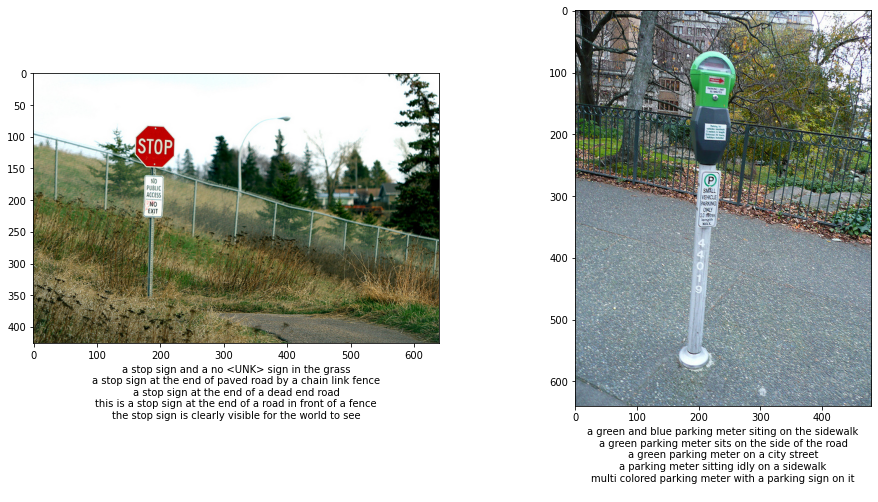

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from util import pil_loader

data = output["test"]

num_images = 2
offset = np.random.randint(0, len(data["img_paths"])-num_images)
scale = 8
rr = int(np.ceil(np.sqrt(num_images)))
fig = plt.figure(figsize=[scale*rr, scale*rr])
fig.patch.set_facecolor('w')

for i in range(num_images):
    fig.add_subplot(rr, rr, i+1)
    ax = plt.gca()

    sub_folder = "train2014" if ("train" in data["img_paths"][offset+i]) else "val2014"
    abs_img_path = os.path.join(coco_image_folder, sub_folder, data["img_paths"][offset+i])
    print(abs_img_path)
    img = pil_loader(abs_img_path)
    ax.imshow(img)
    txt = ""
    for cap_enc, cap_len in zip(data["encoded_captions"][offset+i], data["lengths"][offset+i]):
        words = [vocab_itos.get(int(t), vocab_stoi["<UNK>"]) for t in cap_enc[1:cap_len]]
        txt += " ".join(words) + "\n"

    ax.set_xlabel(txt)

plt.savefig(f"data/test_samples.png", bbox_inches="tight")